# Expected Epidemic Size of Mask Model

$P(A_{L, 0}) = f_0(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(A_{L, 1}) = f_1(P(A_{L - 1, 0}), P(A_{L - 1, 1}))$

$P(\text{wear a mask}) = m$

$A_{L, 0}$ := Node v becomes **active** at level L given he **wear** a mask

$A_{L, 1}$ := Node v becomes **active** at level L given he **doesn't wears** a mask


## 1. Condition on num of neighbors from lower level







$B_k$ := Node v has $k - 1$ lower level neighbors

$P(A_{L, i}) = \sum_{k = 0}^{\infty}{P(A_{L, i} | B_k) * P(B_k)}$

where

$i = 0,1$

$P(B_k) = \frac{k p_{k}}{\langle k\rangle}$




## 2. Condition on num of neighbors wearing a mask

$N$ := Num of neighbors wearing masks 
 
$N \sim \operatorname{Binomial}\left(k - 1, m\right)$


$ P(A_{L, i} | B_k) = \sum_{n = 0}^{k - 1} P(A_{L, i} | B_k, N = n) * \left(\begin{array}{c}
k - 1 \\
n
\end{array}\right) * m^{n} * (1 - m)^{k - 1 - n} $

## 3. Condition on num of active lower level neighbors

$I_0$ := $I_0$ of $k-1$ lower level neighbors active and wear masks

$I_1$ := $I_1$ of $k-1$ lower level neighbors active and don't wear masks

$I_0 \sim \operatorname{Binomial}\left(n, P(A_{L-1,0})\right)$

$I_1 \sim \operatorname{Binomial}\left(k - 1 - n, P(A_{L-1,1})\right)$


$P(A_{L, i} | B_k, N = n) = \sum_{k_0 = 0}^{n}\sum_{k_1 = 0}^{k-1-n}P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1) * \left(\begin{array}{c}
n \\
k_0
\end{array}\right) \left(\begin{array}{c}
k - 1 - n \\
k_1
\end{array}\right) * P(A_{L-1, 0})^{k_0} * (1 - P(A_{L-1,0}))^{n - k_0} * P(A_{L-1, 1})^{k_1} * (1 - P(A_{L-1, 1}))^{k - 1 - n - k_1}$

where

$i = 0,1$

## 4. $P(A_{L, i} | B_k, N = n, I_0 = k_0, I_1 = k_1)$

$R$ := $B_k, N = n, I_0 = k_0, I_1 = k_1$

### 4.1 $P(A_{L,0} | R)$

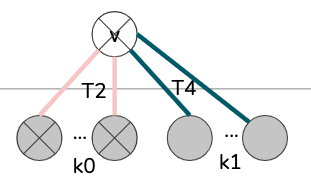

$P(A_{L,0} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v wears a mask} | R)$

$ = 1 - (1 - T_2)^{k_0} * (1 - T_4)^{k_1}$

### 4.1 $P(A_{L,1} | R)$

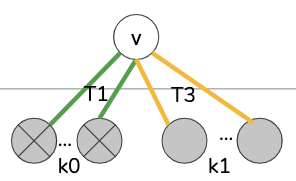

$P(A_{L,1} | R)$

$ = P(\text{At least 1 of node v's active neighbors succssfully infects it, given node v doesn't a mask} | R)$

$ = 1 - (1 - T_1)^{k_0} * (1 - T_3)^{k_1}$

T_mask1 : outward effeciency of masks

T_mask2 : inward effeciency of masks

# Parameters

In [1]:
import re
from os import listdir
from os.path import isfile, join
import json
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
from scipy.special import comb
from scipy import optimize 
import multiprocessing, time
from multiprocessing import Manager
from collections import defaultdict
import collections
# """
# Parameters setup.
# """
# T_mask1 = 0.4 # Outward impact of the mask
# T_mask2 = 0.6 # Inward impact of the mask
# T = 0.6 # Original virus transmissiblity
# m = 0.45 # P(people wear mask)
# nodeN = 200000
# rho = 1.0/nodeN


degree_min = 0
degree_max = 10 # para md in simulation script
interval_num = 50 # para ns in simulation script

# T_list = list(generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m).values())

mean_degree_list = np.linspace(degree_min, degree_max, interval_num)

# max_degree = 2 * degree_max # degree_inf



In [6]:
def generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m):
    T1 = T * T_mask1 
    T2 = T * T_mask1 * T_mask2
    
    T3 = T 
    T4 = T * T_mask2
    
    ## tmask2 ~ 1
    
#     T1 = T * T_mask1 * T_mask2 * m
#     T2 = T * T_mask1 * (1 - m)
#     T3 = T * (1 - m)
#     T4 = T * T_mask2 * m

    
    trans_dict = {'T1': T1,
                  'T2': T2,
                  'T3': T3,
                  'T4': T4}
    
#     print("T1: %.5f" %T1)
#     print("T2: %.5f" %T2)
#     print("T3: %.5f" %T3)
#     print("T4: %.5f" %T4)
    
    return trans_dict    

def generate_new_transmissibilities_mutation(T_mask1, T_mask2, T, m):
    trans_dict = generate_new_transmissibilities_mask(T_mask1, T_mask2, T, m)
    T1 = trans_dict['T1']
    T2 = trans_dict['T2']
    T3 = trans_dict['T3']
    T4 = trans_dict['T4']

    Q1 = T1 * (1 - m) + T2 * m
    Q2 = T3 * (1 - m) + T4 * m

    mu11 = T2 * m / Q1
    mu12 = T1 * (1 - m) / Q1
    mu22 = T3 * (1 - m) / Q2
    mu21 = T4 * m / Q2

    Q_dict = {
        "Q1": Q1,
        "Q2": Q2}
    
    mu_dict = {'mu11': mu11,
               'mu12': mu12,
               'mu22': mu22,
               'mu21': mu21,}
    

#     print("Q1: %.5f" %Q1)
#     print("Q2: %.5f" %Q2)

#     print("mu11: %.5f" %mu11)
#     print("mu12: %.5f" %mu12)
#     print("mu22: %.5f" %mu22)
#     print("mu21: %.5f" %mu21)
    
    print("mu11 + mu12", mu11 + mu12)
    print("mu22 + mu21", mu22 + mu21)
#     assert  == 1
    
    return Q_dict, mu_dict, trans_dict

In [27]:
'''
Collections of data loading functions
'''

def separate_number_chars(s):
    res = re.split('([-+]?\d+\.\d+)|([-+]?\d+)', s.strip())
    res_f = [r.strip() for r in res if r is not None and r.strip() != '']
    return res_f

def load_change_results(change_metric, model_names, paras_setting):
    '''
    Load ES Analysis Results
    Mask: parellel
    Mutation: parellel
    '''

    infection_size = dict()
    for model in model_names:
        infection_size[model] = dict()
        print("Model ", model)
        print("change ", change_metric)
        print(paras_setting)

                
        infection_size[model][change_metric] = dict()
        change_metric_path = model + '_ES_Analysis_change_' + change_metric
        paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]   
        infection_size[model][change_metric][paras_setting] = dict()

        exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Get the latest results
        print(exp_time)

        json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'
        json_path_list = []

        if model == model_names[0]:
            json_path_list.append(json_path + 'infection_size0.json')
            json_path_list.append(json_path + 'infection_size1.json')
            json_path_list.append(json_path + 'infection_size.json')
        else:
            json_path_list.append(json_path + 'infection_size0_mu.json')
            json_path_list.append(json_path + 'infection_size1_mu.json')
            json_path_list.append(json_path + 'infection_size_mu.json')

        
        for i, json_path_i in enumerate(json_path_list):
            with open(json_path_i) as json_file:
                infection_size_mask = json.load(json_file)

            infection_size[model][change_metric][paras_setting][i] = \
            list(collections.OrderedDict(sorted(infection_size_mask.items())).values())

            infection_size[model][change_metric][paras_setting][i] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][i]]
    return infection_size        

def load_change_results_prabh(change_metric, model_names, paras_setting):
    '''
    Load ES Analysis Results
    Mask: ray
    Mutation: parellel
    '''

    infection_size = dict()

    for model in model_names:
        infection_size[model] = dict()
        print("Model ", model)

        print("change ", change_metric)
        infection_size[model][change_metric] = dict()

        change_metric_path = model + '_ES_Analysis_change_' + change_metric
        paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]


        infection_size[model][change_metric][paras_setting] = dict()

        exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) 
                     if f != '.ipynb_checkpoints']



        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)

        json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'
        print(json_path)

        if model == model_names[0]:
            json_path0 = json_path + 'infection_size0.json'
            json_path1 = json_path + 'infection_size1.json'
            json_path2 = json_path + 'infection_size.json'
        else:
            json_path0 = json_path + 'infection_size0_mu.json'
            json_path1 = json_path + 'infection_size1_mu.json'
            json_path2 = json_path + 'infection_size_mu.json'


        with open(json_path0) as json_file:
            infection_size_mask_0 = json.load(json_file)

            if model != model_names[0]:
                infection_size[model][change_metric][paras_setting][0] = \
                list(collections.OrderedDict(sorted(infection_size_mask_0.items())).values())
            else:
                infection_size[model][change_metric][paras_setting][0] = \
                infection_size_mask_0


            infection_size[model][change_metric][paras_setting][0] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][0]]

        with open(json_path1) as json_file:
            infection_size_mask_1 = json.load(json_file)

            if model != model_names[0]:
                infection_size[model][change_metric][paras_setting][1] = \
                list(collections.OrderedDict(sorted(infection_size_mask_1.items())).values())
            else:
                infection_size[model][change_metric][paras_setting][1] = \
                infection_size_mask_1

            infection_size[model][change_metric][paras_setting][1] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][1]]

        with open(json_path2) as json_file:
            infection_size_mask_2 = json.load(json_file)

            if model != model_names[0]:
                infection_size[model][change_metric][paras_setting][2] = \
                list(collections.OrderedDict(sorted(infection_size_mask_2.items())).values())
            else:
                infection_size[model][change_metric][paras_setting][2] = \
                infection_size_mask_2

            infection_size[model][change_metric][paras_setting][2] = \
            [float(i) for i in infection_size[model][change_metric][paras_setting][2]]
    return infection_size  

 
            
def plot_mask_mutation_theory_change(change_metric, mean_degree_list, infection_size, model_names):    
    for paras_setting in infection_size[model_names[0]][change_metric].keys():
        
        paras = paras_setting.split('_')
        m = float(separate_number_chars(paras[0])[1])
        T = float(separate_number_chars(paras[1])[1])
        tm1 = float(paras[3])
        tm2 = float(paras[5])
        print("m: %.2f, T:%.2f, tm1:%.2f, tm2:%.2f" %(m,T,tm1,tm2))

        infection_size_mask = infection_size[model_names[0]][change_metric][paras_setting]
        infection_size_mu   = infection_size[model_names[1]][change_metric][paras_setting]

    
        plt.figure()
#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * m + np.array(infection_size_mask[1]) * (1 - m), 'r.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * m, 'g.')
        plt.plot(mean_degree_list, np.array(infection_size_mask[1]) * (1 - m), 'b.')

#         plt.plot(mean_degree_list, np.array(infection_size_mask[2]) * m, 'g.')
#         plt.plot(mean_degree_list, np.array(infection_size_mask[0]) * (1 - m), 'b.')
# #         plt.plot(mean_degree_list, np.array(infection_size_mask[1]) , 'r.')

        plt.plot(mean_degree_list, np.array(infection_size_mu[2]), 'rx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[0]) , 'gx')
        plt.plot(mean_degree_list, np.array(infection_size_mu[1]) , 'bx')

        plt.legend(["Avg        (Mask model)", "Mask      (Mask model)", "No mask(Mask model)", 
                    "Avg        (Mutation model)", "Strain-1 (Mutation model)", "Strain-2 (Mutation model)"])
        plt.xlabel("Mean Degree")
        plt.ylabel("Infection Fraction")
        title = "Theoretical Epidemic Size\nChange " + change_metric + "\nm:%.2f, T:%.2f, tm1:%.2f, tm2:%.2f"%(m, T, tm1, tm2)
        plt.title(title) 
        
def load_change_results_ray(change_metric, model_names):
    '''
    Load ES Analysis Results
    Mask: ray
    Mutation: ray
    '''
    infection_size = dict()

    for model in model_names:
        infection_size[model] = dict()

        infection_size[model][change_metric] = dict()

        change_metric_path = model + '_ES_Analysis_change_' + change_metric
        paras_settings = [f for f in listdir(change_metric_path) if 'tm' in f]

        for paras_setting in paras_settings:
            print(paras_setting)
            infection_size[model][change_metric][paras_setting] = dict()

            exp_times = [f for f in listdir(change_metric_path + '/' + paras_setting) 
                         if f != '.ipynb_checkpoints']



            exp_time = max(exp_times) # Compare the latest results
            print(exp_time)

            json_path = change_metric_path + '/' + paras_setting + '/' + exp_time + '/' + 'Results/'
            print(json_path)

            if model == model_names[0]:
                json_path0 = json_path + 'infection_size0.json'
                json_path1 = json_path + 'infection_size1.json'
                json_path2 = json_path + 'infection_size.json'
            else:
                json_path0 = json_path + 'infection_size0_mu.json'
                json_path1 = json_path + 'infection_size1_mu.json'
                json_path2 = json_path + 'infection_size_mu.json'


            with open(json_path0) as json_file:
                infection_size_mask_0 = json.load(json_file)


                infection_size[model][change_metric][paras_setting][0] = \
                infection_size_mask_0


                infection_size[model][change_metric][paras_setting][0] = \
                [float(i) for i in infection_size[model][change_metric][paras_setting][0]]

            with open(json_path1) as json_file:
                infection_size_mask_1 = json.load(json_file)


                infection_size[model][change_metric][paras_setting][1] = \
                infection_size_mask_1

                infection_size[model][change_metric][paras_setting][1] = \
                [float(i) for i in infection_size[model][change_metric][paras_setting][1]]

            with open(json_path2) as json_file:
                infection_size_mask_2 = json.load(json_file)


                infection_size[model][change_metric][paras_setting][2] = \
                infection_size_mask_2

                infection_size[model][change_metric][paras_setting][2] = \
                [float(i) for i in infection_size[model][change_metric][paras_setting][2]]
    return infection_size 
        
def load_happyfeet_results(base_happy_path, metric='', para_setting='', exp_setting='', sim_model_name='', start_strain=0, from_sirius = True):
    
    if from_sirius:
        happy_path = base_happy_path + sim_model_name + 'Results_change_' + metric + '/' + para_setting + '/' +  exp_setting

        exp_times = [f for f in listdir(happy_path) 
                 if f != '.ipynb_checkpoints']
        exp_time = max(exp_times) # Compare the latest results
        print(exp_time)

        if start_strain == 0:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss1/'
        else:
            happy_path = happy_path + '/' + exp_time + '/' + 'ss2/'
    else:
        happy_path = base_happy_path
    
    mean_dgree_files = [f for f in listdir(happy_path)]
    
    infection_size0 = defaultdict(list)
    infection_size1 = defaultdict(list)
    
    for idx, mdf in enumerate(mean_dgree_files):
        md = float(separate_number_chars(mdf)[1])
        
        cpfiles = [f for f in listdir(happy_path + mdf)]
        
        infection_size0_cp_list = []
        infection_size1_cp_list = []
        
        for cp_idx, cp in enumerate(cpfiles):
            
            if idx == 0 and cp_idx == 0:
                with open (happy_path + mdf + '/' + cp + '/Settings/paras.json') as jf:
                    paras = json.load(jf)
                    
            np_path = happy_path + mdf + '/' + cp + '/Results/'
            infection_size0_cp_list.append(np.load(np_path + 'infSt1.npy'))
            infection_size1_cp_list.append(np.load(np_path + 'infSt2.npy'))
        
        infection_size0[md] = np.array(infection_size0_cp_list).mean()
        infection_size1[md] = np.array(infection_size1_cp_list).mean()
    
    infection_size0_list = list(collections.OrderedDict(sorted(infection_size0.items())).values())
    infection_size1_list = list(collections.OrderedDict(sorted(infection_size1.items())).values())
            
        
    return infection_size0_list, infection_size1_list, paras     

def load_old_path_sim_results(metric, exp_setting):
    sim_mask_path = '../../../Mask2Results_change_' + metric + '/'
    exp_times = [f for f in listdir(sim_mask_path) 
                     if f != '.ipynb_checkpoints' and exp_setting in f]
    exp_time = max(exp_times) # Compare the latest results
    np_path = sim_mask_path + exp_time + "/Results/start-mask/"
    if0 = np.load(np_path + "infSt1.npy")
    if1 = np.load(np_path + "infSt2.npy")
    
    with open (sim_mask_path + exp_time + "/Settings/paras.json") as js:
        paras_sim = json.load(js)
    return if0, if1, paras_sim

# Mask theory v.s. Mutation theory

In [28]:
########### Sep 10th afternoon

In [29]:
'''Load  ES analysis results'''
m = 0.6
metric_analysis = 'm'
para_setting = 'm'+ str(m) +'_T0.60_tm1_0.00_tm2_1.00'
# model_names = ['Maskplay', 'MutationParellel']
model_names = ['Maskplay', ]
change_metrics_names = ['m', 'T', 'tm']

infection_size = load_change_results(metric_analysis, model_names, para_setting)

Model  Maskplay
change  m
m0.6_T0.60_tm1_0.00_tm2_1.00
091209:29


In [26]:
'''Load simulation results made in Sep 11th using parellel'''
exp_setting = 'n5000_e100'
if0, if1, paras_sim = load_old_path_sim_results(metric_analysis, exp_setting)
paras_sim

{'n': 5000,
 'th': 0.01,
 'tm1': 0.0,
 'tm2': 1.0,
 'm': 0.6,
 'T': 1.0,
 'md': 10,
 'ns': 50,
 'meandegree': 10.0,
 'start_strain ': 2}

In [14]:
# '''Load  simulation results copied from happyfeet'''
# # happy_path = '../../../happyfeet/ss1/'
# # if0, if1, paras = load_happyfeet_results(happy_path, from_sirius = False)

# '''Load  simulation results from sirius(new path)'''
# sim_model_names = ['Mask2']
# base_happy_path = '../../../'
# sim_metric = 'm'
# exp_setting = 'n5000_totalexp100'
# sim_model_name = sim_model_names[0]

# if0, if1, paras = load_happyfeet_results(base_happy_path, sim_metric, 
#                                     para_setting, 
#                                     exp_setting, 
#                                     sim_model_name, 
#                                     2)

# if0, if1, paras = load_happyfeet_results(happy_path, from_sirius = True)

Text(0.5, 1.0, 'Theoretical Epidemic Size\nm0.6_T0.60_tm1_0.00_tm2_1.00')

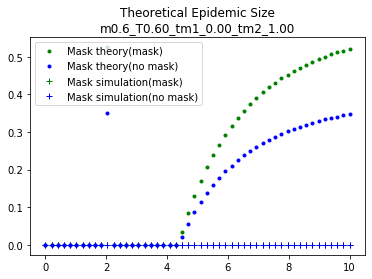

In [15]:
# plt.plot(mean_degree_list, np.array(infection_size[model_names[0]][metric_analysis][para_setting][2]), 'r.')
plt.plot(mean_degree_list, np.array(infection_size[model_names[0]][metric_analysis][para_setting][0]) * m, 'g.')
plt.plot(mean_degree_list, np.array(infection_size[model_names[0]][metric_analysis][para_setting][1]) * (1  - m), 'b.')

# plt.plot(mean_degree_list, np.array(infection_size[model_names[1]][metric][para_setting][0]) + np.array(infection_size[model_names[1]][metric][para_setting][1]), 'rx')
# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][0], 'gx')
# plt.plot(mean_degree_list, infection_size[model_names[1]][metric_analysis][para_setting][1], 'bx')

# plt.plot(mean_degree_list, np.array(if0)  + np.array(if1), 'r+')
plt.plot(mean_degree_list, np.array(if0) , 'g+')
plt.plot(mean_degree_list, np.array(if1) , 'b+')
plt.legend(["Mask theory(mask)", 
            "Mask theory(no mask)",
#             "Mutation theory(Q1)", 
#             "Mutation theory(Q2)",
           "Mask simulation(mask)", 
            "Mask simulation(no mask)",],)
title = "Theoretical Epidemic Size"  + "\n" + para_setting
plt.title(title)
# plot_mask_mutation_theory_change(metric, mean_degree_list, infection_size, model_names)

In [31]:
########### Sep 10th afternoon

Model  MaskbasedonRashad_Parellel
091021:41
Model  MutationParellel
091018:23
m: 0.60, T:0.60, tm1:0.50, tm2:0.50


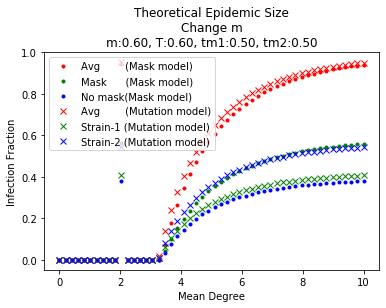

In [177]:
model_names = ['MaskbasedonRashad_Parellel', 'MutationParellel']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results('m', model_names, 'm0.6_T0.60_tm1_0.50_tm2_0.50')
plot_mask_mutation_theory_change('m', mean_degree_list, infection_size, model_names)

Model  Maskplay
091016:32
Model  MutationParellel
091016:36
m: 0.60, T:0.60, tm1:0.50, tm2:0.50


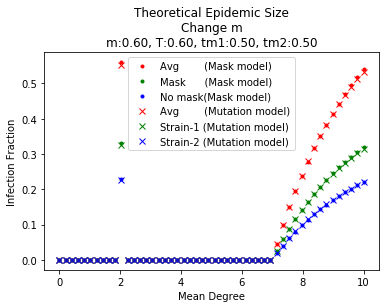

In [29]:
model_names = ['Maskplay', 'MutationParellel']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results('m', model_names, 'm0.6_T0.60_tm1_0.50_tm2_0.50')
plot_mask_mutation_theory_change('m', mean_degree_list, infection_size, model_names)

Model  MaskRay
change  m
090820:49
MaskRay_ES_Analysis_change_m/m0.6_T0.60_tm1_0.40_tm2_0.60/090820:49/Results/
Model  MutationRay
change  m
090820:52
MutationRay_ES_Analysis_change_m/m0.6_T0.60_tm1_0.40_tm2_0.60/090820:52/Results/
m: 0.60, T:0.60, tm1:0.40, tm2:0.60


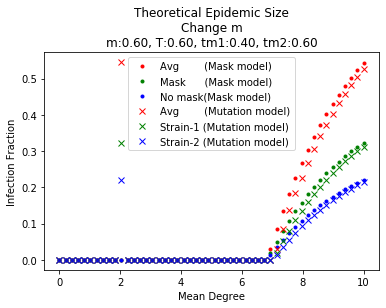

In [64]:
model_names = ['MaskRay', 'MutationRay']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results_prabh('m', model_names, 'm0.6_T0.60_tm1_0.40_tm2_0.60')
plot_mask_mutation_theory_change('m', mean_degree_list, infection_size, model_names)

Model  MaskRay
change  m
090820:49
MaskRay_ES_Analysis_change_m/m0.6_T0.60_tm1_0.50_tm2_0.50/090820:49/Results/
Model  MutationRay
change  m
090820:51
MutationRay_ES_Analysis_change_m/m0.6_T0.60_tm1_0.50_tm2_0.50/090820:51/Results/
m: 0.60, T:0.60, tm1:0.50, tm2:0.50


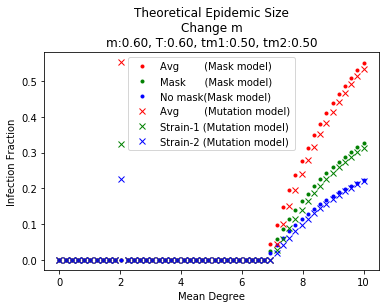

In [65]:
model_names = ['MaskRay', 'MutationRay']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results_prabh('m', model_names, 'm0.6_T0.60_tm1_0.50_tm2_0.50')
plot_mask_mutation_theory_change('m', mean_degree_list, infection_size, model_names)

In [16]:
model_names = ['Mask', 'MutationRay']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results_prabh('m', model_names, 'm0.6_T0.60_tm1_0.50_tm2_0.50')
plot_mask_mutation_theory_change('m', mean_degree_list, infection_size, model_names)

Model  Mask
change  m


FileNotFoundError: [Errno 2] No such file or directory: 'Mask_ES_Analysis_change_m/m0.6_T0.60_tm1_0.50_tm2_0.50'

m: 0.60, T:0.60, tm1:0.40, tm2:0.90
m: 0.20, T:0.60, tm1:0.40, tm2:0.90
m: 0.90, T:0.60, tm1:0.40, tm2:0.60
m: 0.45, T:0.60, tm1:0.40, tm2:0.90
m: 0.60, T:0.60, tm1:0.40, tm2:0.60
m: 0.45, T:0.60, tm1:0.40, tm2:0.60
m: 0.20, T:0.60, tm1:0.40, tm2:0.60
m: 0.90, T:0.60, tm1:0.40, tm2:1.00
m: 0.60, T:0.60, tm1:0.40, tm2:1.00
m: 0.20, T:0.60, tm1:0.40, tm2:1.00
m: 0.45, T:0.60, tm1:0.40, tm2:1.00
m: 0.90, T:0.60, tm1:0.40, tm2:0.90


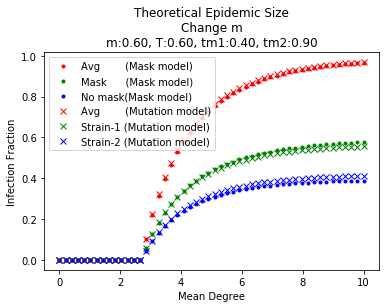

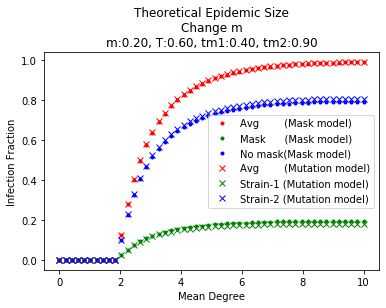

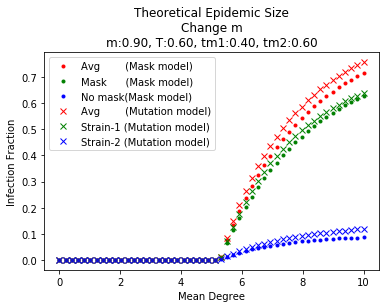

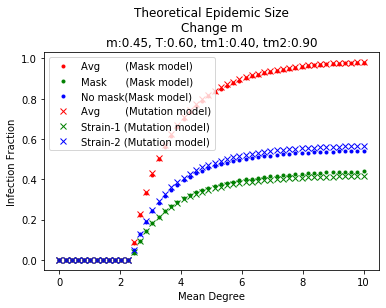

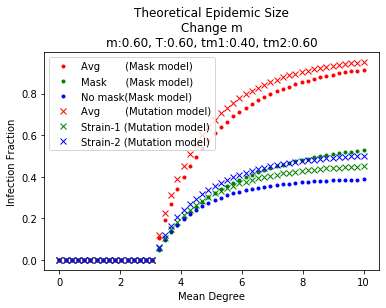

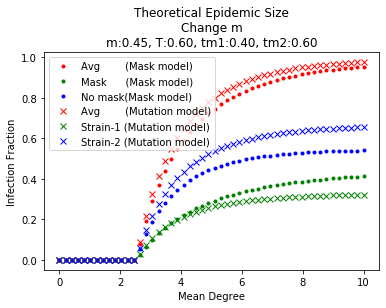

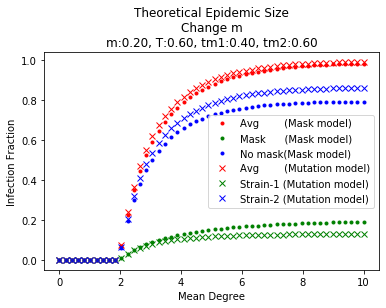

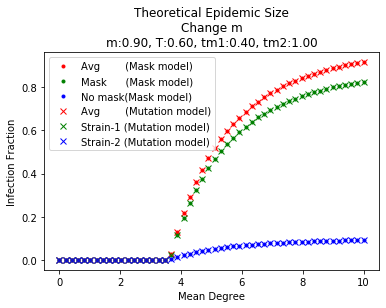

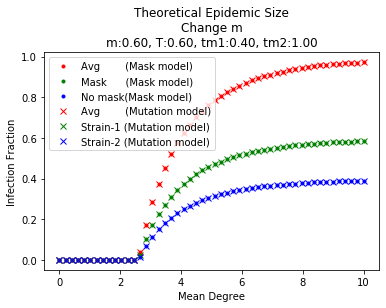

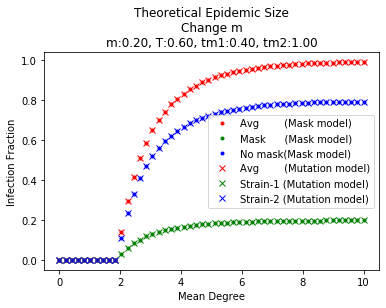

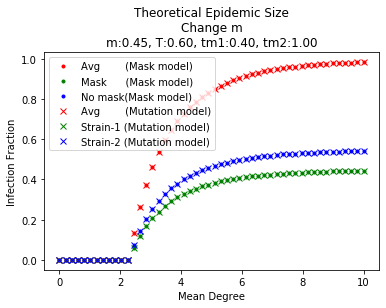

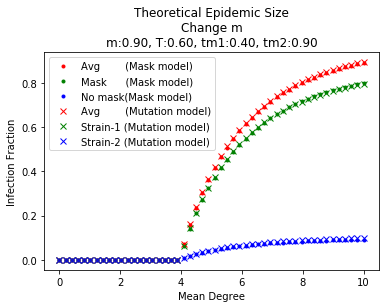

In [17]:
model_names = ['MaskRay', 'MutationRay']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results_ray('m', model_names)
plot_mask_mutation_theory_change('m', mean_degree_list, infection_size, model_names)

m: 0.60, T:0.60, tm1:0.40, tm2:0.90
m: 0.60, T:0.60, tm1:0.40, tm2:0.60
m: 0.60, T:0.80, tm1:0.40, tm2:0.90
m: 0.60, T:0.40, tm1:0.40, tm2:0.60
m: 0.60, T:0.80, tm1:0.40, tm2:0.60
m: 0.60, T:0.40, tm1:0.40, tm2:0.90


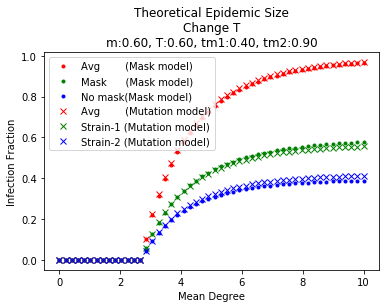

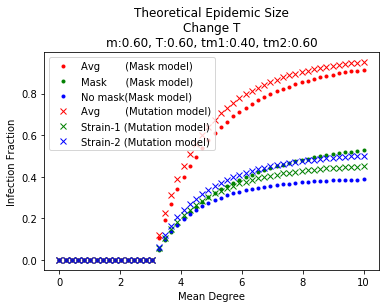

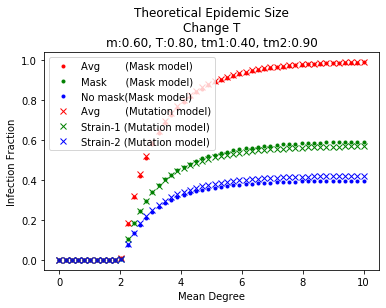

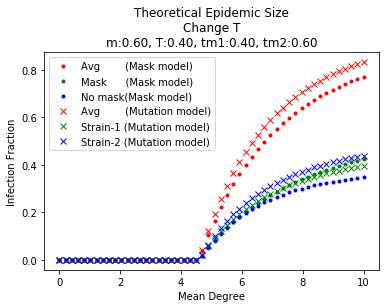

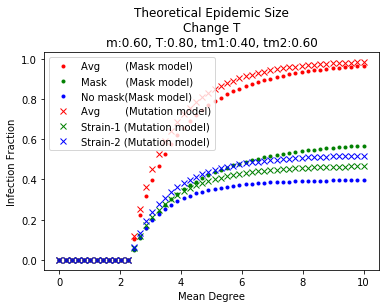

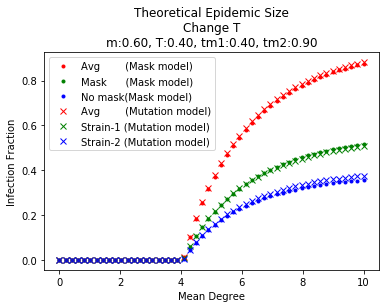

In [9]:
model_names = ['MaskRay', 'MutationRay']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results_ray('T', model_names)
plot_mask_mutation_theory_change('T', mean_degree_list, infection_size, model_names)

m: 0.60, T:0.60, tm1:0.30, tm2:0.90
m: 0.60, T:0.60, tm1:0.30, tm2:0.40
m: 0.60, T:0.60, tm1:0.80, tm2:0.90
m: 0.60, T:0.60, tm1:0.50, tm2:0.90
m: 0.60, T:0.60, tm1:0.80, tm2:0.40
m: 0.60, T:0.60, tm1:0.50, tm2:0.50
m: 0.60, T:0.60, tm1:0.30, tm2:0.60
m: 0.60, T:0.60, tm1:0.80, tm2:0.60
m: 0.60, T:0.60, tm1:0.50, tm2:0.60
m: 0.60, T:0.60, tm1:0.50, tm2:0.40


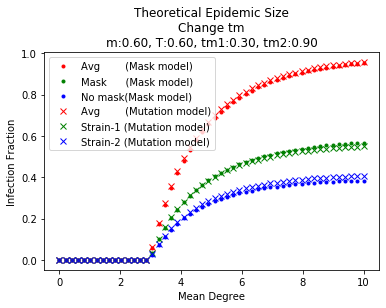

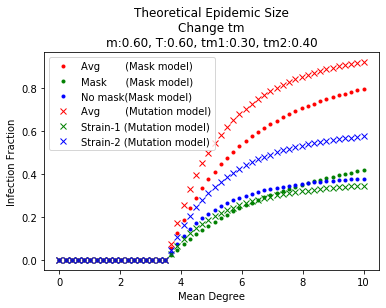

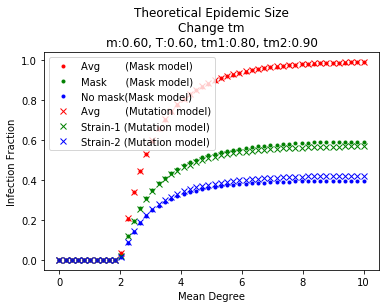

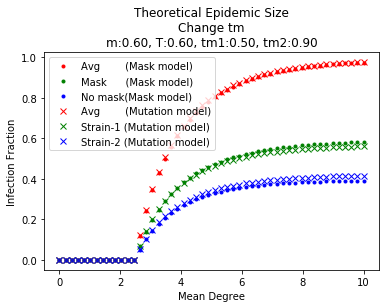

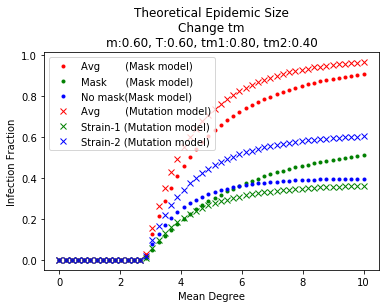

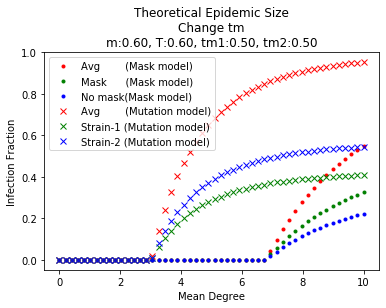

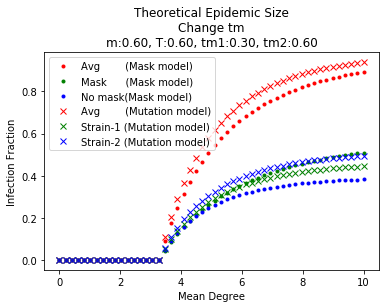

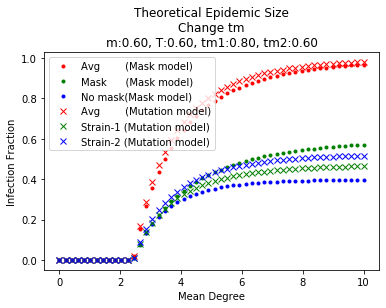

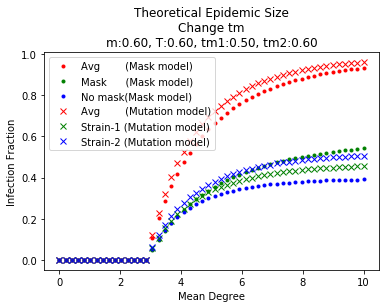

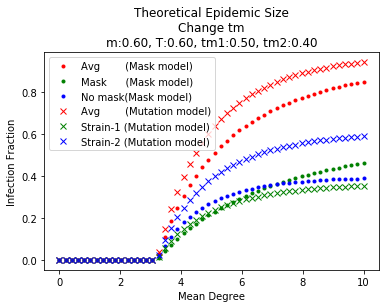

In [5]:
model_names = ['MaskRay', 'MutationRay']
change_metrics_names = ['m', 'T', 'tm']
infection_size = load_change_results_ray('tm', model_names)
plot_mask_mutation_theory_change('tm', mean_degree_list, infection_size, model_names)

# Mask ES

In [3]:
def P_A_given_R(i, T_list, k0, k1):
    one_minus_T1 = 1 - T_list[0]
    one_minus_T2 = 1 - T_list[1]
    one_minus_T3 = 1 - T_list[2]
    one_minus_T4 = 1 - T_list[3]
    
    if i == 0:
        res = 1 - (one_minus_T2 ** k0) * (one_minus_T4 ** k1)
    else:
        res = 1 - (one_minus_T1 ** k0) * (one_minus_T3 ** k1)
    return res

def P_A_given_B_N(i, is_intermediate, k, n, T_list, A_0, A_1):
    one_minus_A0 = 1 - A_0
    one_minus_A1 = 1 - A_1
    p_abn = 0
    
    if is_intermediate:
        k1_range = k - n
    else:
        k1_range = k - n + 1
        
    for k0 in range(n + 1):
        for k1 in range(k1_range):
            p_a_given_r = P_A_given_R(i, T_list, k0, k1)
            p_abn += p_a_given_r * \
                     comb(n, k0) * \
                     comb(k1_range - 1, k1) * \
                     (A_0 ** k0) * \
                     (A_1 ** k1) * \
                     (one_minus_A0 ** (n - k0)) * \
                     (one_minus_A1 ** (k1_range - 1 - k1))
    return p_abn

def P_A_given_B(i, is_intermediate, k, T_list, A_0, A_1, m):
    p_ab = 0
    
    if is_intermediate:
        n_range = k
    else:
        n_range = k + 1
        
    for n in range(n_range):
        p_abn = P_A_given_B_N(i, is_intermediate, k, n, T_list, A_0, A_1)
        p_ab += p_abn * comb(n_range - 1, n) * \
                (m ** n) * \
                ((1 - m) ** (n_range - 1 - n))
    return p_ab

def P_A(i, is_intermediate, mean_degree, nodeN, T_list, m, A_0, A_1):
    pa_L = 0

    for k in range(0, max_degree):
        p_k = poisson.pmf(k, mean_degree)
        if is_intermediate:
            if k == 0: continue #### Sep.5 change
            p_b = k * p_k / mean_degree
        else:
            p_b = p_k
        
        
    

        p_ab = P_A_given_B(i, is_intermediate, k, T_list, A_0, A_1, m)
        pa_L += p_ab * p_b
        
    return rho + (1 - rho)*pa_L

def p_A_vec(mean_degree, nodeN, T_list, m, A_0, A_1, is_intermediate):
    A0 = P_A(0, is_intermediate, mean_degree, nodeN, T_list, m, A_0, A_1)
    A1 = P_A(1, is_intermediate, mean_degree, nodeN, T_list, m, A_0, A_1)
    return [A0, A1]

def func_fix(A, mean_degree, nodeN, T_list, m):
    return np.array(p_A_vec(mean_degree, nodeN, T_list, m, A[0], A[1]))

def func_root(A, mean_degree, nodeN, T_list, m,):
    return np.array(p_A_vec(mean_degree, nodeN, T_list, m, A[0], A[1], True)) - np.array(A)

"""
The only change from the orignial jupyter
"""
def get_EpidemicSize(mean_degree, nodeN, T_list, m):
    ### First solve f(q) = q, then do the ieration for the last level(where everything could reach k) ###
    init_A = (0.9, 0.9)

    A_0_1_root = optimize.fsolve(func_root, init_A, args=(mean_degree, nodeN, T_list, m))
    pa_L_0 = 0
    pa_L_1 = 0
    pa_L = 0
    
    pa_L_0, pa_L_1 = p_A_vec(mean_degree, nodeN, T_list, m, A_0_1_root[0], A_0_1_root[1], False)
    return pa_L_0, pa_L_1, m * pa_L_0 + (1 - m) * pa_L_1, 1 - np.array(A_0_1_root)

infection_size = []
infection_size0 = []
infection_size1 = []

for mean_degree in mean_degree_list:
    print("Mean degree:", mean_degree)
    A_0_1 = get_EpidemicSize(mean_degree, nodeN, T_list, m)
    infection_size.append(A_0_1[2])
    infection_size0.append(A_0_1[0])
    infection_size1.append(A_0_1[1])

np.save("infection_size_md20.npy",infection_size)
np.save("infection_size0_md20.npy",infection_size0)
np.save("infection_size1_md20.npy",infection_size1)

Mean degree: 0.0


NameError: name 'nodeN' is not defined

# Mutation ES

In [35]:
def obtain_val_r_1(v1, v2, t1, lambda_r):
    val = 0

    for d_r in range(0, max_degree):
        if d_r == 0: continue

        prob_r = poisson.pmf(d_r, lambda_r)
        tmp_val = 0

        for k1 in range(0, d_r):
            for k2 in range(0, d_r - k1):
                if k1 == 0 and k2 == 0: continue

                extra_term = 0

                for x in range(1,k1+1):
                    for y in range(1,k2+1):
                        extra_term += comb(k1, x) * comb(k2, y) * t1**x * t2**y *\
                        (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_11+y*u_r_21)/(x+y))

                a1 = (1-t1)**k1
                a2 = (1-t2)**k2
                tmp_val += comb(d_r - 1, k1) * comb(d_r - 1 - k1, k2) *(v1**k1) * (v2 ** k2) * \
                ((1 - v1 - v2) ** (d_r - 1 - k1 - k2)) *\
                (a2*(1-a1)*u_r_11 + a1*(1-a2)*u_r_21  + extra_term )

        val += d_r*prob_r*1.0/lambda_r * tmp_val

    return rho + (1 - rho)*val  #### 2. Why need to this? Shouldn't return val as q_{l + 1, i}? #### 
                                #=> rho: frac of seeds

def obtain_val_r_2(v1, v2, t2, lambda_r):
    val = 0

    for d_r in range(0, max_degree):
        if d_r == 0: continue
        prob_r = poisson.pmf(d_r, lambda_r)
        tmp_val = 0


        for k1 in range(0, d_r):
            for k2 in range(0, d_r - k1):
                if k1 == 0 and k2 == 0: continue

                extra_term = 0

                for x in range(1,k1+1):
                    for y in range(1,k2+1):
                        extra_term += comb(k1, x) * comb(k2, y) * t1**x * \
                        t2**y * (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_12+y*u_r_22)/(x+y))

                a1 = (1-t1)**k1
                a2 = (1-t2)**k2
                tmp_val += comb(d_r - 1, k1) * comb(d_r - 1 - k1, k2) *(v1**k1) * (v2 ** k2) * \
                ((1 - v1 - v2) ** (d_r - 1 - k1 - k2)) *\
                (a2*(1-a1)*u_r_12 + a1*(1-a2)*u_r_22  + extra_term )

        val += d_r*prob_r*1.0/lambda_r * tmp_val

    return rho + (1 - rho)*val #### 2. Why need to this? Shouldn't return val as q_{l + 1, i}? #### 

def equations(p):
    v1, v2 = p
    val_r_1 = obtain_val_r_1(v1, v2, t1, lambda_r)
    val_r_2 = obtain_val_r_2(v1, v2, t2, lambda_r)

    return (v1 - val_r_1, v2 - val_r_2) 


def cascade_size(lambda_r):
    
    h_r_1, h_r_2 = optimize.fsolve(equations, (0.9, 0.9), xtol=1e-10) 

    H = 0
    H1 = 0
    H2 = 0
    
    for d_r in range(0, max_degree): 
        prob_r = poisson.pmf(d_r, lambda_r)
        tmp_val1 = 0
        tmp_val2 = 0

        for k1 in range(0, d_r + 1):
            for k2 in range(0, d_r + 1 - k1):
                extra_term_1 = 0
                extra_term_2 = 0
                for x in range(1,k1+1):
                    for y in range(1,k2+1):
                        extra_term_1 += comb(k1, x) * comb(k2, y) * t1**x *\
                        t2**y * (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_11+y*u_r_21)/(x+y))
                        extra_term_2 += comb(k1, x) * comb(k2, y) * t1**x *\
                        t2**y * (1-t1)**(k1-x) * (1-t2)**(k2-y) *\
                        ((x*u_r_12+y*u_r_22)/(x+y))

                a1 = (1-t1)**k1
                a2 = (1-t2)**k2
                tmp_val1 += comb(d_r , k1) * comb(d_r - k1, k2) *(h_r_1**k1) * (h_r_2 ** k2) * \
                ((1 - h_r_1 - h_r_2) ** (d_r - k1 - k2)) *\
                (a2*(1-a1)*u_r_11 + a1*(1-a2)*u_r_21  + extra_term_1 )

                tmp_val2 += comb(d_r, k1) * comb(d_r - k1, k2) *(h_r_1**k1) * (h_r_2 ** k2) * \
                ((1 - h_r_1 - h_r_2) ** (d_r - k1 - k2)) *\
                (a2*(1-a1)*u_r_12 + a1*(1-a2)*u_r_22  + extra_term_2 )

        H += prob_r * (tmp_val1 + tmp_val2) 
        H1 += prob_r * tmp_val1
        H2 += prob_r * tmp_val2

    return (lambda_r, H, H1, H2, h_r_1, h_r_2)

def parse_args(args):
    parser = argparse.ArgumentParser(description = 'Parameters')
    parser.add_argument('-m', type = float, nargs = '+', default = np.arange(0.1, 10.1, 0.1), \
    help='np.linspace(0.001, 12, 100) (default); list of mean degree: you can type 1 3 5')
    parser.add_argument('-t1', type = float, default = 0.044, \
     help='0.5 (default); the transmissibility of strain-1')
    parser.add_argument('-t2', type = float, default = 0.12, \
    help='0.5 (default); the transmissibility of strain-2')
    parser.add_argument('-m1', type = float, default = 0.75, \
    help='0.5 (default); the mutation probability from 1 to 1')
    parser.add_argument('-m2', type = float, default = 0.75, \
    help='0.5 (default); the mutation probability from 2 to 2')
    return parser.parse_args(args)

    
q_dict, mu_dict = generate_new_transmissibilities_mutation(T_mask1, T_mask2, T, m)

t1 = q_dict['Q1']
t2 = q_dict['Q2']
m1 = mu_dict['mu11']
m2 = mu_dict['mu22']


infection_size_mu = []
infection_size0_mu = []
infection_size1_mu = []

u_r_11 = m1
u_r_12 = 1-u_r_11
u_r_22 = m2
u_r_21 = 1-u_r_22

for lambda_r in mean_degree_list:
    print("mean_degree:", lambda_r)

    
    lambda_r, H, H1, H2, h_r_1, h_r_2 = cascade_size(lambda_r)
    
    infection_size_mu.append(H) 
    infection_size0_mu.append(H1)
    infection_size1_mu.append(H2)


Q1: 0.05730
Q2: 0.57300
mu11: 0.42408
mu12: 0.57592
mu22: 0.57592
mu21: 0.42408
mean_degree: 0.0


/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


mean_degree: 0.20408163265306123
mean_degree: 0.40816326530612246
mean_degree: 0.6122448979591837
mean_degree: 0.8163265306122449
mean_degree: 1.0204081632653061
mean_degree: 1.2244897959183674
mean_degree: 1.4285714285714286
mean_degree: 1.6326530612244898
mean_degree: 1.836734693877551
mean_degree: 2.0408163265306123
mean_degree: 2.2448979591836737
mean_degree: 2.4489795918367347
mean_degree: 2.6530612244897958
mean_degree: 2.857142857142857
mean_degree: 3.0612244897959187
mean_degree: 3.2653061224489797
mean_degree: 3.4693877551020407
mean_degree: 3.673469387755102
mean_degree: 3.8775510204081636
mean_degree: 4.081632653061225
mean_degree: 4.285714285714286
mean_degree: 4.4897959183673475
mean_degree: 4.6938775510204085
mean_degree: 4.8979591836734695
mean_degree: 5.1020408163265305
mean_degree: 5.3061224489795915
mean_degree: 5.510204081632653
mean_degree: 5.714285714285714
mean_degree: 5.918367346938775
mean_degree: 6.122448979591837
mean_degree: 6.326530612244898
mean_degree: 6.5

In [207]:
resuls_path1 = 'Mask_ES_Analysis_change_m/m0.45_T0.60_tm1_0.40_tm2_0.60/090717:06'

with open(resuls_path1 + '/' + 'Results/infection_size.json') as jf:
    infection_size = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
with open(resuls_path1 + '/' + 'Results/infection_size0.json') as jf:
    infection_size0 = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
with open(resuls_path1 + '/' + 'Results/infection_size1.json') as jf:
    infection_size1 = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
    
    
    
# resuls_path2 = 'Mask_ES_Analysis_change_m/m0.45_T0.60_tm1_0.40_tm2_0.60/090716:57'

# with open(resuls_path2 + '/Results/infection_size.json') as jf:
#     _infection_size = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
# with open(resuls_path2 + '/Results/infection_size0.json') as jf:
#     _infection_size0 = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
# with open(resuls_path2 + '/Results/infection_size1.json') as jf:
#     _infection_size1 = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
    
resuls_path2 = 'Mutation_ES_Analysis_change_m/m0.45_T0.60_tm1_0.40_tm2_0.60/090617:59'

with open(resuls_path2 + '/Results/infection_size_mu.json') as jf:
    _infection_size = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
with open(resuls_path2 + '/Results/infection_size0_mu.json') as jf:
    _infection_size0 = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
with open(resuls_path2 + '/Results/infection_size1_mu.json') as jf:
    _infection_size1 = list(collections.OrderedDict(sorted(json.load(jf).items())).values())
    
# with open('Mask_ES_Analysis_change_m/m0.45_T0.60_tm1_0.40_tm2_0.60/090716:46/Results/infection_size0.json') as jf:
#     infection_size0 = json.load(jf)
    
# with open('Mask_ES_Analysis_change_m/m0.45_T0.60_tm1_0.40_tm2_0.60/090716:46/Results/infection_size1.json') as jf:
#     infection_size1 = json.load(jf)

FileNotFoundError: [Errno 2] No such file or directory: 'Mask_ES_Analysis_change_m/m0.45_T0.60_tm1_0.40_tm2_0.60/090717:06/Results/infection_size.json'

Text(0.5, 1.0, 'Theoretical Epidemic Size')

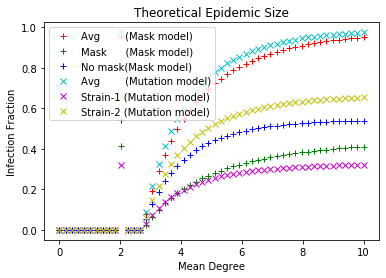

In [156]:
m = 0.45

plt.figure()
plt.plot(mean_degree_list, infection_size, 'r+')
plt.plot(mean_degree_list, np.array(infection_size0) * m, 'g+')
plt.plot(mean_degree_list, np.array(infection_size1) * (1 - m), 'b+')

# plt.plot(mean_degree_list, infection_size_mu, 'cx')
# plt.plot(mean_degree_list, np.array(infection_size0_mu) , 'mx')
# plt.plot(mean_degree_list, np.array(infection_size1_mu) , 'yx')

plt.plot(mean_degree_list, _infection_size, 'cx')
plt.plot(mean_degree_list, np.array(_infection_size0) , 'mx')
plt.plot(mean_degree_list, np.array(_infection_size1) , 'yx')

plt.legend(["Avg        (Mask model)", "Mask      (Mask model)", "No mask(Mask model)", 
            "Avg        (Mutation model)", "Strain-1 (Mutation model)", "Strain-2 (Mutation model)"])
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Theoretical Epidemic Size"
plt.title(title)

# Mask theory v.s. simulation

In [11]:
# sim_mask_avg_size = np.load("../../../Mask2Results/081615:48_n2000000_e1000/Results/AvgValidSize.npy")
# sim_mask_size1 = np.load("../../../Mask2Results/081615:48_n2000000_e1000/Results/infSt1.npy")
# sim_mask_size2 = np.load("../../../Mask2Results/081615:48_n2000000_e1000/Results/infSt2.npy")

# sim_mask_path = '../../../Mask2Results/082822:20_n2000000_e100/Results/start-mask/'
sim_mask_path = '../../../Mask2Results/m0.45/T0.60/tm1_0.10_tm2_0.90/090421:49_n5000_e100/Results/start-mask/'

sim_mask_avg_size = np.load(sim_mask_path + "AvgValidSize.npy")
sim_mask_size1 = np.load(sim_mask_path + "infSt1.npy")
sim_mask_size2 = np.load(sim_mask_path + "infSt2.npy")


# sim_mu_avg_size = np.load("../../../MutationResults/082317:14_n2000000_e100/Results/start-s1/AvgValidSize.npy")
# sim_mu_size1 = np.load("../../../MutationResults/082317:14_n2000000_e100/Results/start-s1/infSt1.npy")
# sim_mu_size2 = np.load("../../../MutationResults/082317:14_n2000000_e100/Results/start-s1/infSt2.npy")

Text(0.5, 1.0, 'Epidemic Size for Mask Model\ntm1: 0.40, tm2: 0.60, T: 0.60, m: 0.45')

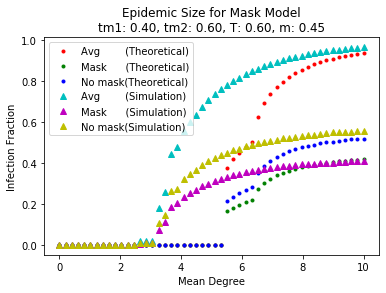

In [56]:
plt.figure()

plt.plot(mean_degree_list, infection_size, 'r.')
plt.plot(mean_degree_list, np.array(infection_size0) * m, 'g.')
plt.plot(mean_degree_list, np.array(infection_size1) * (1 - m), 'b.')

# plt.plot(mean_degree_list, infection_size_mu, 'cv')
# plt.plot(mean_degree_list, np.array(infection_size0_mu) , 'mv')
# plt.plot(mean_degree_list, np.array(infection_size1_mu) , 'yv')


plt.plot(mean_degree_list, sim_mask_avg_size, 'c^')
plt.plot(mean_degree_list, sim_mask_size1, 'm^')
plt.plot(mean_degree_list, sim_mask_size2, 'y^')

# plt.plot(mean_degree_list, sim_mu_avg_size, 'cv')
# plt.plot(mean_degree_list, sim_mu_size1 , 'mv')
# plt.plot(mean_degree_list, sim_mu_size2 , 'yv')

plt.legend(["Avg        (Theoretical)", "Mask      (Theoretical)", "No mask(Theoretical)", 
            "Avg        (Simulation)",  "Mask      (Simulation)",  "No mask(Simulation)"])
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Epidemic Size for Mask Model\ntm1: %.2f, tm2: %.2f, T: %.2f, m: %.2f"%(T_mask1, T_mask2, T, m)
plt.title(title)

Text(0.5, 1.0, 'Epidemic Size for Mutation Model')

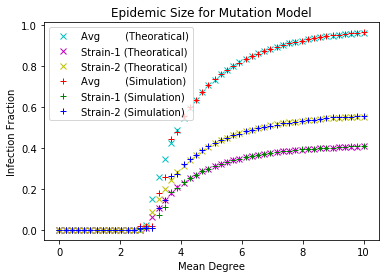

In [54]:
plt.figure()

# plt.plot(mean_degree_list, infection_size, 'rx')
# plt.plot(mean_degree_list, np.array(infection_size0) * m, 'gx')
# plt.plot(mean_degree_list, np.array(infection_size1) * (1 - m), 'bx')

plt.plot(mean_degree_list, infection_size_mu, 'cx')
plt.plot(mean_degree_list, np.array(infection_size0_mu) , 'mx')
plt.plot(mean_degree_list, np.array(infection_size1_mu) , 'yx')


# plt.plot(mean_degree_list, sim_mask_avg_size, 'r+')
# plt.plot(mean_degree_list, sim_mask_size1 , 'g+')
# plt.plot(mean_degree_list, sim_mask_size2 , 'b+')

# plt.plot(mean_degree_list, sim_mu_avg_size, 'c+')
# plt.plot(mean_degree_list, sim_mu_size1 , 'm+')
# plt.plot(mean_degree_list, sim_mu_size2 , 'y+')


plt.plot(mean_degree_list, sim_mask_avg_size, 'r+')
plt.plot(mean_degree_list, sim_mask_size1 , 'g+')
plt.plot(mean_degree_list, sim_mask_size2 , 'b+')


plt.legend(["Avg        (Theoratical)", "Strain-1 (Theoratical)", "Strain-2 (Theoratical)", 
            "Avg        (Simulation)",  "Strain-1 (Simulation)",  "Strain-2 (Simulation)"])
plt.xlabel("Mean Degree")
plt.ylabel("Infection Fraction")
title = "Epidemic Size for Mutation Model"
plt.title(title)